# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [370]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [301]:
# load data from database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Raw_data_clean.db')
df = pd.read_sql("SELECT * FROM RawData", engine)

In [302]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [347]:
categories = df.drop(columns = ['id', 'message', 'original', 'genre', 'child_alone'])

In [349]:
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now let's do some visualizations for the data. Code adapted from this [post](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff).

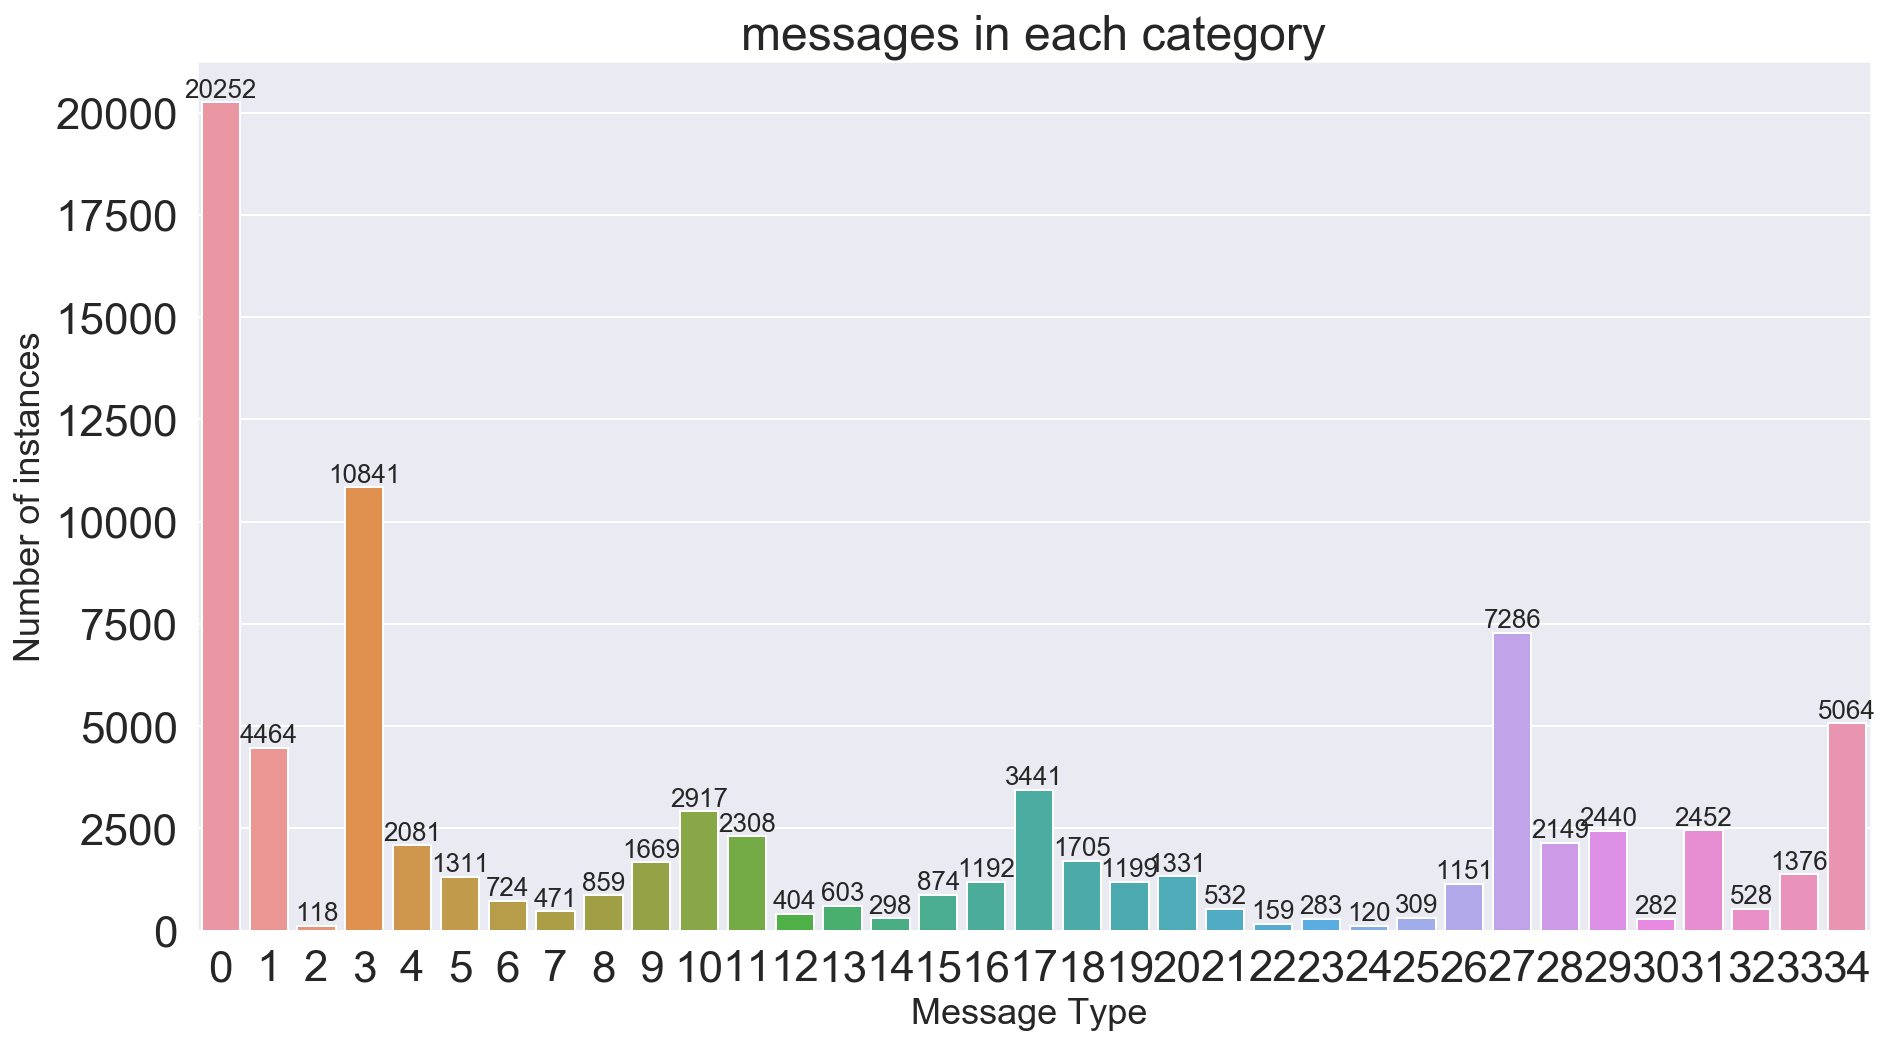

In [371]:
# cats = list(categories.columns.values)
cats = list(range(categories.shape[1])) # replace the name of categories into numbers
counts = categories.sum().values
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(cats, counts)
plt.title("messages in each category", fontsize=24)
plt.ylabel('Number of instances', fontsize=18)
plt.xlabel('Message Type ', fontsize=18)
#adding the text labels
rects = ax.patches
for rect, count in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, count, ha='center', va='bottom', fontsize=13)
plt.show()

In [391]:
criteria = (counts/categories.shape[0]) < 0.05
categories.columns.values[criteria]

We can see that several message types are very rare, i.e., the data set is imbalanced.
Let's pull the names of all the imbalanced set defined as follows:

In [404]:
criteria = (counts/categories.shape[0]) < 0.03 #less than 3% of data are positive lables
categories.columns.values[criteria]

array(['offer', 'search_and_rescue', 'security', 'clothing', 'money',
       'missing_people', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'fire', 'cold'], dtype=object)

Next we inspect the distribution of multilabels, i.e., how many labels do one message get?

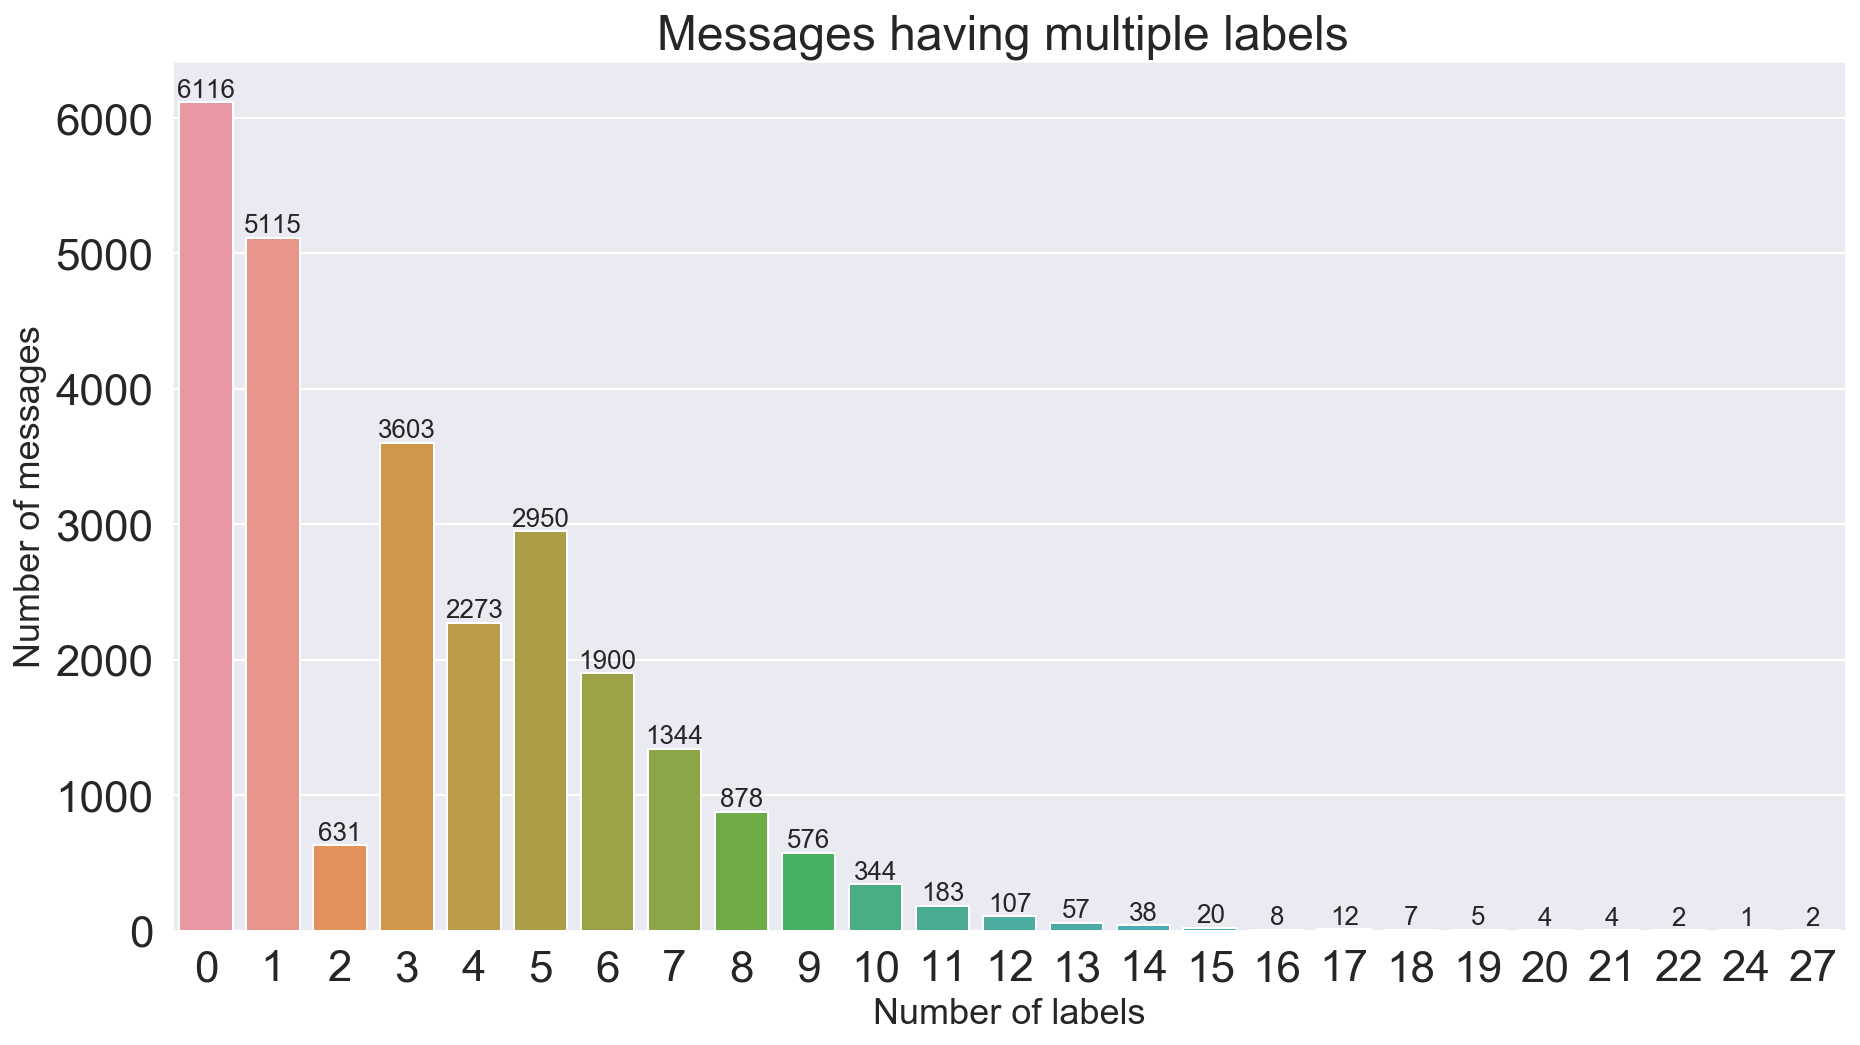

In [420]:
rowSums = categories.sum(axis=1)
multiLabel_counts = rowSums.value_counts().sort_index()
# multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Messages having multiple labels ")
plt.ylabel('Number of messages', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize=13)
plt.show()

Other than an outlier 2, the rest of the data clearly shows the trend that the number of messages decreases with labels. And over 23% of the messages even don't have any labels.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

### 2. Write a tokenization function to process your text data

In [32]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [34]:
import re

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

In [59]:
tokenized = []
for msg in df['message']:
    tokenized.append(tokenize(msg))

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [310]:
from sklearn.naive_bayes import ComplementNB
pipe = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
    ('clf', RandomForestClassifier())
])

In [331]:
base_lr = LogisticRegression()
pipe = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
    ('clf', OneVsRestClassifier(base_lr)),
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [346]:
frac = 0.75 # partition between train and test set
categories = df.drop(columns = ['id', 'message', 'original', 'genre', 'child_alone']).to_numpy()
X_train, X_test = df['message'][:int(frac*len(df))].to_numpy(), df['message'][int(frac*len(df)):].to_numpy()
Y_train, Y_test = categories[:int(frac*len(df))], categories[int(frac*len(df)):]
# convert 1, 0 to True, False
Y_train, Y_test = np.ma.make_mask(Y_train, shrink=False), np.ma.make_mask(Y_test, shrink=False)  

In [332]:
pipe.fit(X_train, Y_train)
Y_pred = pipe.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred, average='samples')

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [321]:
from sklearn import metrics
target_names = df.drop(columns = ['id', 'message', 'original', 'genre', 'child_alone']).columns.values
report = metrics.classification_report(Y_test, Y_pred, target_names = target_names, output_dict=True)
report = pd.DataFrame(report).transpose()

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [318]:
report['support'].sort_values()

shops                        29.0
offer                        38.0
tools                        56.0
fire                         64.0
missing_people               67.0
clothing                     82.0
cold                         82.0
hospitals                   115.0
aid_centers                 127.0
money                       156.0
security                    174.0
electricity                 188.0
search_and_rescue           213.0
earthquake                  241.0
storm                       305.0
request                     308.0
death                       323.0
refugees                    339.0
other_weather               340.0
buildings                   365.0
other_infrastructure        388.0
transport                   422.0
water                       435.0
direct_report               437.0
medical_products            448.0
military                    552.0
food                        561.0
infrastructure_related      581.0
shelter                     607.0
floods        

In [333]:
report[report['precision'] == 0.0]

,precision,recall,f1-score,support
offer,0.0,0.0,0.0,38.0
security,0.0,0.0,0.0,174.0
missing_people,0.0,0.0,0.0,67.0
tools,0.0,0.0,0.0,56.0
hospitals,0.0,0.0,0.0,115.0
shops,0.0,0.0,0.0,29.0
aid_centers,0.0,0.0,0.0,127.0


In [337]:
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(X_train)

In [339]:
x_test = vectorizer.transform(X_test)

In [341]:
x_test.shape, x_train.shape

((6545, 28748), (19635, 28748))

In [342]:
from sklearn.multioutput import ClassifierChain
chains = [ClassifierChain(base_lr, order='random', random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(x_train, Y_train)

Y_pred_chains = np.array([chain.predict(x_test) for chain in
                          chains])
chain_jaccard_scores = [jaccard_score(Y_test, Y_pred_chain >= .5,
                                      average='samples')
                        for Y_pred_chain in Y_pred_chains]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

In [343]:
Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(Y_test,
                                       Y_pred_ensemble >= .5,
                                       average='samples')

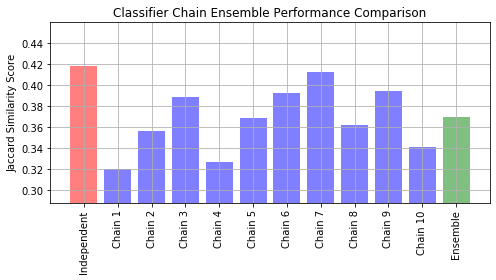

In [345]:
model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = ('Independent',
               'Chain 1',
               'Chain 2',
               'Chain 3',
               'Chain 4',
               'Chain 5',
               'Chain 6',
               'Chain 7',
               'Chain 8',
               'Chain 9',
               'Chain 10',
               'Ensemble')

x_pos = np.arange(len(model_names))
fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp
from shutil import rmtree
cachedir = mkdtemp()
pipe = Pipeline(estimators, memory=cachedir)
parameters = 

cv = 

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.